# IBM Data Science Professional Specialization - Coursera

This notebook is for the capstone project for the 9-courses specialization in [Data Science of IBM on Coursera](https://www.coursera.org/specializations/ibm-data-science-professional-certificate). Data Science Specialization
This project will try to solve a problem or question by applying data science methods on the location data gotten from FourSquare API.

In [7]:
# !conda install -c conda-forge beautifulsoup4 --yes

# !conda install -c conda-forge geopy --yes

# !conda install -c conda-forge folium=0.5.0 --yes

print('Libraries installed!')

Libraries installed!


In [4]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
import json

from bs4 import BeautifulSoup

from geopy.geocoders import Nominatim

import folium
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.preprocessing import StandardScaler, normalize, scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

print('Libraries imported!')

Libraries imported!


## I. Project Summary:

Using data science techniques to analyze the following questions:

* Is the surrounding venues can effect the price of real estates?
* What kind of surrounding venues, and to what extend, can effect the price?
* Can we use the surrounding venue to estimate the value of an accommodation over the average price of one area? And to what degree of confidence?

The data will be:

* Average price of 2-bedrooms condos in New York city's neighborhoods. (CityRealty)
* Venues surrounding each neighborhoods. (FourSquare API)

Target audiences will be:

* Home buyers, who can roughly estimate the value of a target house over the average.
* Planners, who can decide which venues to place around their product, so that the price is maximized.
* Any normal person, who is wondering if that in-process building will effect his/her home's value.

## II. Prepare the data:

### 1. Get the neighborhoods coordinate:

Free geodata is available free at: https://github.com/benbalter/dc-maps

A copy has been downloaded and stored in IBM cloud

In [5]:
# Download the geodata
!wget -q -O 'dc_geo.json' https://raw.githubusercontent.com/benbalter/dc-maps/master/maps/neighborhood-names-centroid.geojson
print('Data downloaded!')

Data downloaded!


In [6]:
# Load the json file
with open('dc_geo.json') as dc_geo_json:
    dc_geo_data = json.load(dc_geo_json)

In [7]:
# Get the neighborhoods list
dc_geo_list = dc_geo_data['features']

# Sample neighborhood node
dc_geo_list[0]

{'type': 'Feature',
 'properties': {'OBJECTID': 1,
  'GIS_ID': 'nhood_132',
  'NAME': 'Stronghold',
  'WEB_URL': 'http://op.dc.gov',
  'LABEL_NAME': 'Stronghold',
  'DATELASTMODIFIED': '2003-04-10T00:00:00.000Z'},
 'geometry': {'type': 'Point',
  'coordinates': [-77.0077674102066, 38.92577558252441]}}

In [8]:
# Parse the json data into neighborhoods list
neighborhood_geo_list = []
for data in dc_geo_list:
   
    neighborhood_name = data['properties']['NAME']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhood_geo_list.append((
       neighborhood_name, neighborhood_lat, neighborhood_lon
    ))

In [9]:
# Put into a dataframe
neighborhood_geo_df = pd.DataFrame(neighborhood_geo_list)
neighborhood_geo_df.columns = ['Neighborhood', 'Latitude', 'Longitude']

# Avg price data is only available for Manhattan and Brooklyn
#neighborhood_geo_df = neighborhood_geo_df[(neighborhood_geo_df['Borough'] == 'Manhattan') | (neighborhood_geo_df['Borough'] == 'Brooklyn')]

neighborhood_geo_df.reset_index(drop=True, inplace=True)

In [10]:
print(neighborhood_geo_df.shape)
neighborhood_geo_df.head()

(131, 3)


,Neighborhood,Latitude,Longitude
0,Stronghold,38.925776,-77.007767
1,Langston,38.901336,-76.972367
2,Downtown East,38.895428,-77.014234
3,Colonial Village,38.986790,-77.041094
4,Shepherd Park,38.982980,-77.032126


### 2. download and clean Zillow website data for neighborhoods home value index:

**What's the Zillow Home Value Index?**

Before we tackle the Zillow Home Value Index, be sure to learn about the Zestimate home valuation, since this is the building block for the Zillow Home Value Index. A Zestimate is Zillow’s estimate of the current market value for a home. We have tens of millions of Zestimates – one for most homes. Our data is refreshed regularly to reflect real estate transactions that could affect you – even if you’re not buying or selling a house.

We download this index for all type of house in D.C. Neighboorhoods, we clean the data set and we made a csv file contains just neighboorhood and Zillow
index in each row, for more details about how this index calculated visit [this](https://www.zillow.com/info/whats-the-zillow-home-value-index/) page.

For getting data set visit this page:  [washington D.C zillow data](https://www.zillow.com/washington-dc/home-values/)

In [11]:
!wget -q -O "zillow-dc.csv" https://raw.githubusercontent.com/aminoskouei/IBM-Data-Science/master/zillow-dc.csv
#print('Neighborhood Price downloaded!')
zillow_dc = pd.read_csv('zillow-dc.csv')

In [12]:
print(zillow_dc.shape)
zillow_dc.head()

(78, 2)


,neighborhood,All homes
0,Adams Morgan,"565,700"
1,American University Park,"1,043,400"
2,Barnaby Woods,"1,085,500"
3,Barney Circle,"776,000"
4,Benning,"326,600"


### 3. Combine the two dataframes:
There are three problems here causing the number of neighborhoods doesn't match:

* First, Zillow price data isn't available to all neighborhoods.
* Second, some neighborhoods name scrapped from the website is not same as their corresponding ones in the geo dataset.
* Third, real estate market names some neighborhoods differently, or make up of new names. All for the purpose of sale.

Each line of price data will be considered, and suitable action will be performed:

* If the names is different, decide which one to use after searching on the internet.
* If the neighborhood is missing from the geo datafram, add it's coordinate.


After editing the zillow in the Excel, we deleted the neighborhood that data is not available for, then we match the name of the neighborhood of zillow 
with the geojson neighborhood name. Then i uploaded this new zillow data set and we use that to make inner-join between this two data sets.


In [13]:
!wget -q -O "zillow-dc.csv" https://raw.githubusercontent.com/aminoskouei/IBM-Data-Science/master/zillow-dc-v2.csv
#print('Neighborhood Price downloaded!')
zillow_dc_new = pd.read_csv('zillow-dc.csv')

In [14]:
print(zillow_dc_new.shape)
zillow_dc_new.head()

(74, 2)


,Neighborhood,Zillow-price
0,Adams Morgan,"565,700"
1,American University Park,"1,043,400"
2,Barnaby Woods,"1,085,500"
3,Benning,"326,600"
4,Benning Ridge,"323,200"


#### Inner join the two dataframes by Neighborhoods

In [15]:
!wget -q -O "innerjoin-dc.csv" https://github.com/aminoskouei/IBM-Data-Science/raw/master/innerjoin-dc.csv
#print('Neighborhood Price downloaded!')
dc_neighborhood_price_df = pd.read_csv('innerjoin-dc.csv')

In [16]:
# The joined dataframe
print(dc_neighborhood_price_df.shape)
dc_neighborhood_price_df['Zillow-Price'].apply(lambda x:float(x))
dc_neighborhood_price_df.head()

(73, 4)


,Neighborhood,Longitude,Latitude,Zillow-Price
0,Adams Morgan,-77.042391,38.920472,565700
1,American University Park,-77.090250,38.947612,1043400
2,Barnaby Woods,-77.060174,38.975433,1085500
3,Benning,-76.948884,38.891885,326600
4,Benning Ridge,-76.938203,38.881162,323200


### 4. Visualize the data onto a map

In [17]:
latitude = '38.9072'
longitude = '-77.009003'

print('Washington D.C. cordinates:')
print('lat: ' + latitude)
print('long:' + longitude)

Washington D.C. cordinates:
lat: 38.9072
long:-77.009003


#### Using Folium to create a Map of Washington D.C. with price markers on top

In [18]:
map_dc = folium.Map(location=[38.9072, -77.009003], zoom_start=11)

# add markers to map
for lat, lng, neighborhood, price in zip(dc_neighborhood_price_df['Latitude'],dc_neighborhood_price_df['Longitude'], dc_neighborhood_price_df['Neighborhood'], dc_neighborhood_price_df['Zillow-Price']):
    label = '{}, ${:3.0f}'.format(neighborhood, price)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='Blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dc)

# display map
map_dc


### 5. Using FourSquare API to get surrounding venues:

In [19]:
CLIENT_ID = '5LCOWRSOOBERWFQWQOF11VSTPQQU12NQK5R4ETGVES1C3ELA' # your Foursquare ID
CLIENT_SECRET = 'B0OC10NHX3IYERVXXKK3UXSN0PPODFWRT1GU2DRD4P2UULTK' # your Foursquare Secret
VERSION = '20190330' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5LCOWRSOOBERWFQWQOF11VSTPQQU12NQK5R4ETGVES1C3ELA
CLIENT_SECRET:B0OC10NHX3IYERVXXKK3UXSN0PPODFWRT1GU2DRD4P2UULTK


In [109]:
# FourSquare parameters
radius = 1500 # 1.6 km around the neighborhood center
limit = 300

venues = []

for lat, long, neighborhood in zip(dc_neighborhood_price_df['Latitude'], dc_neighborhood_price_df['Longitude'], 
                                   dc_neighborhood_price_df['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        limit)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [110]:
# put the venues into a dataframe
venues_df = pd.DataFrame(venues)
venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueType']

# check the dataframe
print(venues_df.shape)
print('There are {} unique venue types.'.format(len(venues_df['VenueType'].unique())))
venues_df.head()

(5313, 7)
There are 305 unique venue types.


,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueType
0,Adams Morgan,38.920472,-77.042391,Lapis,38.921302,-77.043890,Afghan Restaurant
1,Adams Morgan,38.920472,-77.042391,The Green Zone,38.919483,-77.041845,Cocktail Bar
2,Adams Morgan,38.920472,-77.042391,Smoke & Barrel,38.922266,-77.042286,BBQ Joint
3,Adams Morgan,38.920472,-77.042391,Donburi,38.921673,-77.042385,Japanese Restaurant
4,Adams Morgan,38.920472,-77.042391,Tryst,38.921916,-77.042329,Coffee Shop


In [111]:
# one hot encoding
venues_type_onehot = pd.get_dummies(venues_df[['VenueType']], prefix="", prefix_sep="")

# add the neighborhood column
venues_type_onehot['Neighborhood'] = venues_df['Neighborhood']
fix_columns = list(venues_type_onehot.columns[-1:]) + list(venues_type_onehot.columns[:-1])
venues_type_onehot = venues_type_onehot[fix_columns]

print(venues_type_onehot.shape)
venues_type_onehot.head()

(5313, 305)


,Zoo Exhibit,ATM,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boarding House,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Chaat Place,Chinese Restaurant,Chiropractor,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Library,College Quad,College Rec Center,College Residence Hall,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Courthouse,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Mountain,Movie Theater,Museum,Music Store,Music Venue,National Park,Neighborhood,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Sculpture,Pakistani Restaurant,Paper / Office Supplies Store,Park,Parking,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,Road,Rock Club,Roller Rink,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stables,Stadium,Steakhouse,Storage Facility,Strip Club,Student Center,Supermarket,Sushi Restaurant,Swiss Restaurant,Synagogue,Taco Place,Tailor Sh

In [112]:
# get the occurrence of each venue type in each neighborhood
venue_count_df = venues_type_onehot.groupby(['Neighborhood']).sum().reset_index()

print(venue_count_df.shape)
venue_count_df.head()

(73, 305)


,Neighborhood,Zoo Exhibit,ATM,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boarding House,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Chaat Place,Chinese Restaurant,Chiropractor,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Library,College Quad,College Rec Center,College Residence Hall,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Courthouse,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Mountain,Movie Theater,Museum,Music Store,Music Venue,National Park,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Sculpture,Pakistani Restaurant,Paper / Office Supplies Store,Park,Parking,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,Road,Rock Club,Roller Rink,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stables,Stadium,Steakhouse,Storage Facility,Strip Club,Student Center,Supermarket,Sushi Restaurant,Swiss Restaurant,Synagogue,Taco Place,Tailor Sh

In [113]:
# get the standardized neighborhoods' average prices
scaler = StandardScaler()
standardized_price = scaler.fit_transform(dc_neighborhood_price_df[['Zillow-Price']])

# add the normalized price to the dataframe
neighborhood_venues_withprice_df = pd.DataFrame(venue_count_df)
neighborhood_venues_withprice_df['StandardizedAvgPrice'] = standardized_price

print(neighborhood_venues_withprice_df.shape)
neighborhood_venues_withprice_df.head()

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(73, 306)


,Neighborhood,Zoo Exhibit,ATM,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boarding House,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Chaat Place,Chinese Restaurant,Chiropractor,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Library,College Quad,College Rec Center,College Residence Hall,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Courthouse,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Mountain,Movie Theater,Museum,Music Store,Music Venue,National Park,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Sculpture,Pakistani Restaurant,Paper / Office Supplies Store,Park,Parking,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,Road,Rock Club,Roller Rink,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stables,Stadium,Steakhouse,Storage Facility,Strip Club,Student Center,Supermarket,Sushi Restaurant,Swiss Restaurant,Synagogue,Taco Place,Tailor Sh

#### This is the end of data collecting and preprocessing
_neighborhood_venues_withpricedf will be the dataframe that will be used in the analyzing step below

## III. Analyze the dataframe:

### 1. Check for correlation between occurrence of surrounding venues with real estate average price:

In [120]:
# Using LinearRegression, we can get the list of coefficient correlations between each type of venue and the average price
lreg = LinearRegression(normalize=True)

X = neighborhood_venues_withprice_df.drop(columns=['Neighborhood', 'StandardizedAvgPrice'])
y = neighborhood_venues_withprice_df['StandardizedAvgPrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = lreg.fit(X_train, y_train)

In [121]:
# let's see how well Linear Regression fit the problem
y_pred = lreg.predict(X_test)

print('R2-score:', r2_score(y_test, y_pred)) # r2 score
print('Mean Squared Error:', mean_squared_error(y_test, y_pred)) # mse

print('Max positive coefs:', lreg.coef_[np.argsort(-lreg.coef_)[:10]])
print('Venue types with most postive effect:', X.columns[np.argsort(-lreg.coef_)[:10]].values)
print('Max negative coefs:', lreg.coef_[np.argsort(lreg.coef_)[:10]])
print('Venue types with most negative effect:', X.columns[np.argsort(lreg.coef_)[:10]].values)
coef_abs = abs(lreg.coef_)
print('Min coefs:', lreg.coef_[np.argsort(coef_abs)[:10]])
print('Venue types with least effect:', X.columns[np.argsort(coef_abs)[:10]].values)

R2-score: -0.47930992498036096
Mean Squared Error: 0.9324551521577173
Max positive coefs: [0.61929811 0.59880177 0.49479214 0.49479214 0.49324561 0.49285314
 0.47855573 0.475512   0.47155398 0.45666477]
Venue types with most postive effect: ['Historic Site' 'Skating Rink' 'Stadium' 'Roller Rink' 'Bus Line' 'Track'
 'General College & University' 'Botanical Garden' 'Souvenir Shop'
 'Baseball Stadium']
Max negative coefs: [-1.10310265 -0.56537993 -0.44723784 -0.44139399 -0.42661253 -0.42638938
 -0.42638938 -0.41100021 -0.35216761 -0.35216761]
Venue types with most negative effect: ['ATM' 'Harbor / Marina' 'Lake' 'Arcade' 'Herbs & Spices Store' 'Parking'
 'Fish & Chips Shop' 'Sculpture Garden' 'Storage Facility'
 'Video Game Store']
Min coefs: [ 0.          0.          0.          0.          0.          0.
  0.         -0.00010522  0.00073216 -0.0010244 ]
Venue types with least effect: ['Jewelry Store' 'Shoe Repair' 'Laundromat' 'Jazz Club'
 'Leather Goods Store' 'Lebanese Restaurant' 'O

The result doesn't look promising:

The R2 score is negative.
* There are no really strong coefficient correlations.
* Looking back to our dataset, we can see that the features is much bigger than the samples.

PCR (Principal Component Regression) will be used to reduce the number of features.

### 2. Applying PCR for better result:

PCR is a regression technique which is based on PCA (Principle Component Analysis).
It's a two steps process:

* First, perform PCA on the features set to obtain the principle components. Then select a subset for the next step.
* Second, use regression on the previous subset of principal components to get a list of coefficient correlations. (Linear Regression will be used)

In [122]:
X = neighborhood_venues_withprice_df.drop(columns=['Neighborhood', 'StandardizedAvgPrice'])
y = neighborhood_venues_withprice_df['StandardizedAvgPrice']

# First, apply PCA
pca = PCA(svd_solver='auto', random_state=0)
X_pca = pca.fit_transform(scale(X))

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by the scale function.
  


In [123]:
n_component_list = range(1, 74)
r2_list = []
mse_list = []

# Second, Linear Regression
for i in n_component_list:
    lreg = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(X_pca[:,:i], y, test_size=0.2, random_state=0)
    model = lreg.fit(X_train, y_train)
    # check the result
    y_pred = lreg.predict(X_test)
    r2 = r2_score(y_test, y_pred) # r2 score
    mse = mean_squared_error(y_test, y_pred) # mse
    r2_list.append(r2)
    mse_list.append(mse)
    
scores_df = pd.DataFrame.from_dict(dict([('NComponents', n_component_list),
                                        ('R2', r2_list),
                                        ('MSE', mse_list)]))
scores_df.set_index('NComponents', inplace=True)

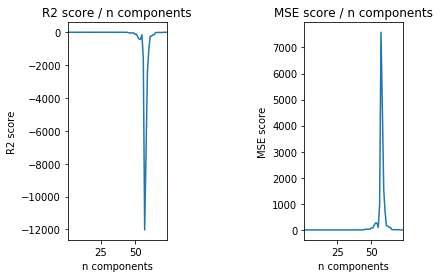

In [124]:
# plot the scores to see the best n_components
plt.subplot(1, 3, 1)
scores_df['R2'].plot(kind='line')
plt.title('R2 score / n components')
plt.ylabel('R2 score')
plt.xlabel('n components')

plt.subplot(1, 3, 3)
scores_df['MSE'].plot(kind='line')
plt.title('MSE score / n components')
plt.ylabel('MSE score')
plt.xlabel('n components')

plt.show()

In [125]:
r2_max = scores_df['R2'].idxmax()
print("Best n:", r2_max, "R2 score:", scores_df['R2'][r2_max])

mse_min = scores_df['MSE'].idxmin()
print("Best n:", mse_min, "MSE:", scores_df['MSE'][mse_min])

Best n: 1 R2 score: -0.057128474003405705
Best n: 1 MSE: 0.6663410252521544


In [126]:
# Use the best n_components parameter
lreg = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X_pca[:,:r2_max], y, test_size=0.2, random_state=0)
model = lreg.fit(X_train, y_train)

# check the result
y_pred = lreg.predict(X_test)
r2 = r2_score(y_test, y_pred) # r2 score
mse = mean_squared_error(y_test, y_pred) # mse
print("R2 score:", r2)
print("MSE:", mse)

R2 score: -0.057128474003405705
MSE: 0.6663410252521544


The result seems to improved compared to just using simple Linear Regression.

In [127]:
# Let's try to project the coefs back to the original number of features
eigenvectors = pca.components_
pcr_coefs = eigenvectors[:r2_max, :].T @ lreg.coef_

pcr_coefs.shape

(304,)

In [128]:
# Let's check which venue types effect the most and least
print('Max positive coefs:', pcr_coefs[np.argsort(-pcr_coefs)[:10]])
print('Venue types with most positive effect:', X.columns[np.argsort(-pcr_coefs)[:10]].values)
print('Max negative coefs:', pcr_coefs[np.argsort(pcr_coefs)[:10]])
print('Venue types with most negative effect:', X.columns[np.argsort(pcr_coefs)[:10]].values)
coef_abs = abs(pcr_coefs)
print('Min coefs:', pcr_coefs[np.argsort(coef_abs)[:10]])
print('Venue types with least effect:', X.columns[np.argsort(coef_abs)[:10]].values)

Max positive coefs: [0.00251286 0.00245616 0.00243678 0.00236941 0.002362   0.00236048
 0.00236034 0.0022442  0.00218617 0.00214282]
Venue types with most positive effect: ['Italian Restaurant' 'Cycle Studio' 'Salad Place' 'Ramen Restaurant'
 'New American Restaurant' 'Cocktail Bar' 'Ice Cream Shop'
 'Mediterranean Restaurant' 'Portuguese Restaurant' 'Theater']
Max negative coefs: [-0.00197313 -0.00167736 -0.00146918 -0.00131823 -0.00130322 -0.00127971
 -0.00127394 -0.0012362  -0.00120696 -0.00119246]
Venue types with most negative effect: ['Convenience Store' 'Pharmacy' 'Chinese Restaurant' 'Rental Car Location'
 'Video Store' 'Fast Food Restaurant' 'Mobile Phone Shop' 'Intersection'
 'Gas Station' 'Metro Station']
Min coefs: [-1.95104888e-05  2.85982565e-05  2.89792404e-05 -4.07235638e-05
 -4.07456446e-05  4.21252420e-05  4.70390463e-05  4.70390463e-05
  4.95027603e-05 -6.37871196e-05]
Venue types with least effect: ['Golf Course' 'Lounge' 'Waterfront' 'Track' 'Pool' 'Sports Bar'
 'L

## IV. Conclusion:
Again, the result doesn't seems very promising as the R2 score is still small. The machine learning models can't be used to predict precisely a neighborhood's average house price.

Based on the observed coefficient correlations, fancy places like restaurants seem to boost real estate's value the most.
In some ways, it's a logical conclusion. Neighborhoods that have many restaurants are most likely business areas such as downtown. It's where lots of people go to, lots of activities to enjoy, lots of other businesses, .... The kind of places that people like to live at or closeby.
And as a result of high demand, the price will be higher than other more rural neighborhoods.